In [1]:
from f_drosophila_infer import *
from f_train import *
from f_data_prep import *
from sklearn import linear_model

In [2]:
data_all = np.loadtxt('../data_complete.txt')
# data_all = data_all - np.median(data_all, axis=0)
all_bin = np.vsplit(data_all, 6)
all_init = np.vstack([all_bin[i] for i in range(5)])
all_diff = np.vstack([all_bin[i+1]-all_bin[i] for i in range(5)])

complete_all = ([int(x) - 1 for x in open('../indices_complete.txt','r').readline().split()])
comp_ind = list(map(int, list((np.array(complete_all)[::6]-3)/6)))

data_comp = np.copy(data_all[:, comp_ind])
comp_bin = np.vsplit(data_comp, 6)
comp_init = np.vstack([comp_bin[i] for i in range(5)])
comp_diff = np.vstack([comp_bin[i+1] - comp_bin[i] for i in range(5)])

all_init, all_diff, comp_init, comp_diff = shuffle(all_init, all_diff, comp_init, comp_diff)

In [3]:
# def ER_cv_quad(X, y, gene_comp=comp_ind, kf=10, power_=0):
#     quad = np.copy(X)
#     kfold = KFold(n_splits=kf, shuffle=False, random_state=1)
    
#     error_list=[]
#     if len(gene_comp) == 0:
#         for i in range(X.shape[1]-1):
#             for j in range(i+1, X.shape[1]):
#                 quad = np.hstack((quad, (X[:,i]*X[:,j])[:,None]))
#     else:
#         for i in range(len(comp_ind)-1):
#             for j in range(i+1, len(comp_ind)):
#                 quad = np.hstack((quad, (X[:,comp_ind[i]]*X[:,comp_ind[j]])[:,None]))
            
#     for (tr, te) in (kfold.split(y)):
#         X_tr, quad_tr, y_tr = X[tr], quad[tr], y[tr]
#         X_te, quad_te, y_te = X[te], quad[te], y[te]
        
#         if y.shape[1] == len(gene_comp):
#             X_init = np.copy(X_te[:, comp_ind])
#         else:
#             X_init = np.copy(X_te)
        
#         y_actual = X_init + y_te
#         y_actual_sum_sq = np.sum(np.abs(y_actual)**2, axis=0)
        
#         w,sigma,bias = infer_drosophila(quad_tr, y_tr, power=power_, l=10)
#         noise = sigma*npr.normal(size=(1,w.shape[1]))
            
#         if power_ == 0:
#             y_pred = X_init + (bias + quad_te.dot(w) + noise)
#         if power_ == 1:
#             y_pred = X_init + (np.tanh(bias + quad_te.dot(w)) + noise)
#         if power_ == 3:
#             y_pred = X_init + (odd_power(bias + quad_te.dot(w), power_) + noise)
        
#         error = (np.sum(np.abs(y_pred - y_actual)**2, axis=0)/y_actual_sum_sq)**(1/2)
#         error_list.append(error)
#     return [np.mean(error_list, axis=0), np.std(error_list, axis=0)]

# def infer_all_ER(X_all, X_comp, y_all, y_comp, func=0):
#     res=[]
#     results = ER_cv_quad(X_all, y_all, gene_comp=comp_ind, kf=10, power_=func)
#     res.append(results)
#     results = ER_cv_quad(X_all, y_comp, gene_comp=comp_ind, kf=10, power_=func)
#     res.append(results)
#     results = ER_cv_quad(X_comp, y_comp, gene_comp=[], kf=10, power_=func)
#     res.append(results)
#     return res

In [4]:
def skl_cv_quad(X, y, gene_comp=comp_ind, kf=10):
    kfold = KFold(n_splits=kf, shuffle=False)
    
    if len(gene_comp) > 0:
        X_in = np.copy(X[:, comp_ind])
    else:
        X_in = np.copy(X)
        
    quad = np.copy(X_in)
    
    error_list=[]
    w_list = []
    bias_list = []
    yp_list = []
    if len(gene_comp) > 0:
        for i in range(X_in.shape[1]-1):
            for j in range(i+1, X_in.shape[1]):
                quad = np.hstack((quad, (X_in[:,i]*X_in[:,j])[:,None]))
    else:
        for i in range(len(comp_ind)-1):
            for j in range(i+1, len(comp_ind)):
                quad = np.hstack((quad, (X_in[:,comp_ind[i]]*X_in[:,comp_ind[j]])[:,None]))
            
    for (cell_tr, cell_te) in (kfold.split(range(6078))):
        te = np.hstack([cell_te+(6078*i) for i in range(5)])
        tr = np.hstack([cell_tr+(6078*i) for i in range(5)])
        X_tr, quad_tr, y_tr = X[tr], quad[tr], y[tr]
        X_te, quad_te, y_te = X[te], quad[te], y[te]
        
        regr = linear_model.LinearRegression()
        regr.fit(quad_tr, y_tr)
        w_list.append(regr.coef_.T)
        bias_list.append(regr.intercept_)
        
        if y.shape[1] == 27:
            X_init = np.copy(X[:, comp_ind][te])
        else:
            X_init = np.copy(X[te])
        
        y_actual = X_init + y_te
        y_actual_sum_sq = np.sum(np.abs(y_actual)**2, axis=0)
        
        y_pred = X_init + regr.predict(quad_te)
#         yp_list.append(np.copy(y_pred))
        y_pred[y_pred < 0] = 0
        
        error = (np.sum(np.abs(y_pred - y_actual)**2, axis=0)/y_actual_sum_sq)**(1/2)
        error_list.append(error)
    print(X_init.shape[1], quad_te.shape[1], regr.coef_.shape)
    return [np.mean(error_list, axis=0), np.std(error_list, axis=0), w_list, bias_list]

def infer_all_skl(X_all, y_all, y_comp):
    res=[]
    results = skl_cv_quad(X_all, y_all, gene_comp=[], kf=10)
    res.append(results)
    results = skl_cv_quad(X_all, y_comp, gene_comp=[], kf=10)
    res.append(results)
    results = skl_cv_quad(X_all, y_all, gene_comp=comp_ind, kf=10)
    res.append(results)
    results = skl_cv_quad(X_all, y_comp, gene_comp=comp_ind, kf=10)
    res.append(results)
    return res

In [5]:
# ER_quad = infer_all_ER(all_init, comp_init, all_diff, comp_diff, func=1)    
# skl_quad = infer_all_skl(all_init, all_diff, comp_diff)

In [6]:
# with open('./pickles/ER_quad.pkl', 'wb') as f:
#     pickle.dump(ER_quad, f)
# with open('./pickles/skl_quad.pkl', 'wb') as f:
#     pickle.dump(skl_quad, f)

In [7]:
# with open('./pickles/ER_quad.pkl', 'rb') as f:
#     ER_quad = pickle.load(f)
with open('./pickles/skl_quad.pkl', 'rb') as f:
    skl_quad = pickle.load(f)

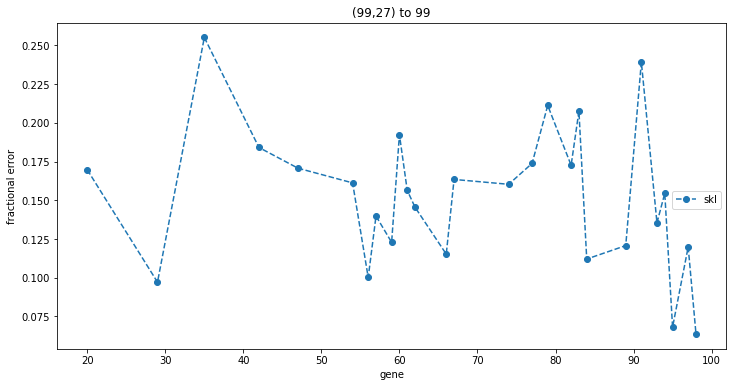

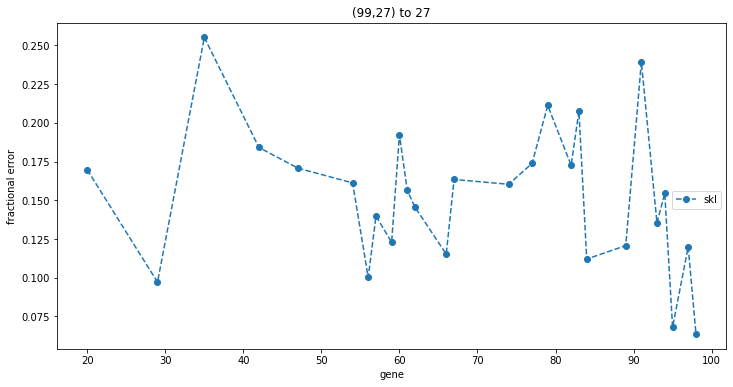

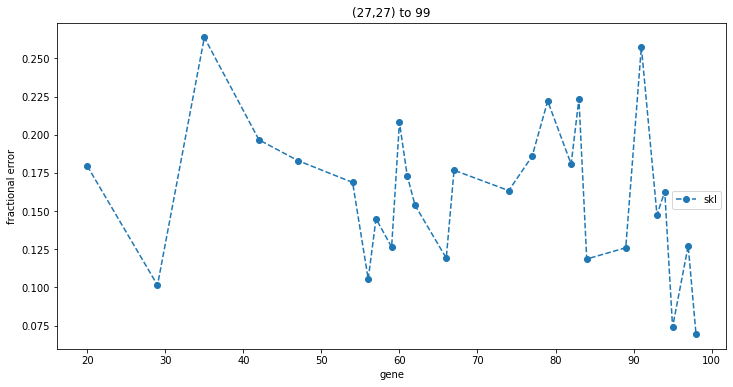

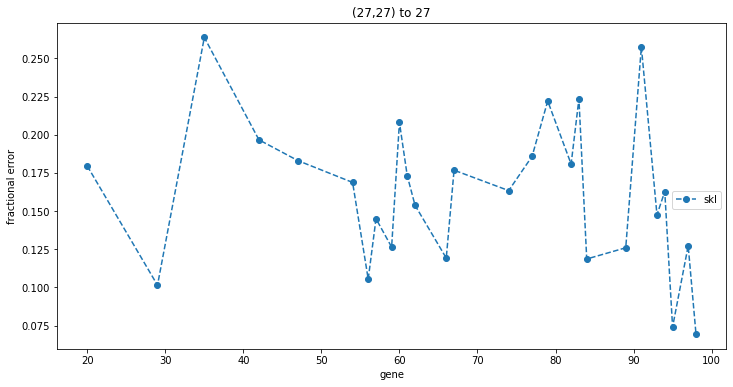

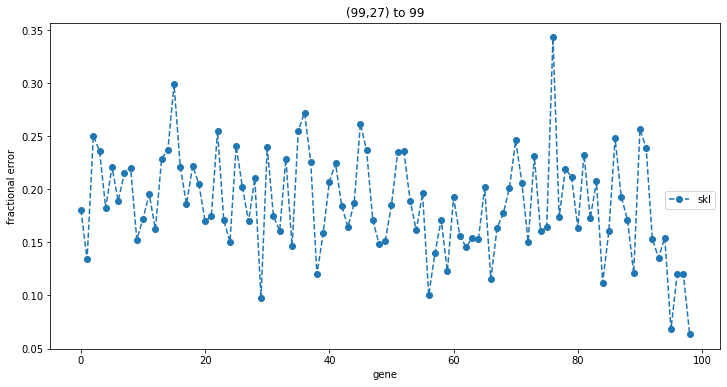

In [8]:
%matplotlib inline
labels=['(99,27) to 99', '(99,27) to 27', '(27,27) to 99', '(27,27) to 27']
for i in range(4):
    plt.figure(figsize=(12,6))
    if i == 0 or i == 2:
#         plt.plot(comp_ind, ER_quad[i][0][comp_ind], 'o--', label='ER')
        plt.plot(comp_ind, skl_quad[i][0][comp_ind], 'o--', label='skl')
    else:
#         plt.plot(comp_ind, ER_quad[i][0], 'o--', label='ER')
        plt.plot(comp_ind, skl_quad[i][0], 'o--', label='skl')
    plt.title(labels[i])
    plt.legend(bbox_to_anchor=(1,0.5))
    plt.xlabel('gene')
    plt.ylabel('fractional error')
#     plt.ylim(0,1)
    plt.show()

plt.figure(figsize=(12,6))
# plt.plot(range(99), ER_quad[0][0], 'o--', label='ER')
plt.plot(range(99), skl_quad[0][0], 'o--', label='skl')
plt.legend(bbox_to_anchor=(1,0.5))
plt.title('(99,27) to 99')
plt.xlabel('gene')
plt.ylabel('fractional error')
# plt.ylim(0,1)
plt.show()

In [9]:
def skl_cv_quad(X, y, kf=10):
    kfold = KFold(n_splits=kf, shuffle=False)
    
    quad = np.zeros((int(X.shape[0]), int(X.shape[1]+(X.shape[1]*(X.shape[1]-1))/2)))
    quad[:,:X.shape[1]] = np.copy(X)
    col = 99
    for i in range(X.shape[1]-1):
        for j in range(i+1, X.shape[1]):
            quad[:,col] = (X[:,i]*X[:,j])
            col += 1
    error_list=[]
    w_list = []
    bias_list = []
    yp_list = []
    for (cell_tr, cell_te) in (kfold.split(range(6078))):
        te = np.hstack([cell_te+(6078*i) for i in range(5)])
        tr = np.hstack([cell_tr+(6078*i) for i in range(5)])
        X_tr, quad_tr, y_tr = X[tr], quad[tr], y[tr]
        X_te, quad_te, y_te = X[te], quad[te], y[te]
        
        regr = linear_model.LinearRegression()
        regr.fit(quad_tr, y_tr)
        w_list.append(regr.coef_.T)
        bias_list.append(regr.intercept_)
        
        X_init = np.copy(X[te])
        
        y_actual = X_init + y_te
        y_actual_sum_sq = np.sum(np.abs(y_actual)**2, axis=0)
        
        y_pred = X_init + regr.predict(quad_te)
#         yp_list.append(np.copy(y_pred))
        y_pred[y_pred < 0] = 0
        
        error = (np.sum(np.abs(y_pred - y_actual)**2, axis=0)/y_actual_sum_sq)**(1/2)
        error_list.append(error)
    print(X_init.shape[1], quad_te.shape[1], regr.coef_.T.shape)
    return [np.mean(error_list, axis=0), np.std(error_list, axis=0), w_list, bias_list]

In [10]:
# results = skl_cv_quad(all_init, all_diff, kf=10)

# with open('./pickles/skl_(99,99)_tt.pkl', 'wb') as f:
#     pickle.dump(results, f)

In [11]:
with open('./pickles/validation_cells.pkl', 'rb') as f:
    cells_v = pickle.load(f)

In [12]:
data_all = np.loadtxt('../data_complete.txt')
# data_all = data_all - np.median(data_all, axis=0)
all_bin = np.vsplit(data_all, 6)
all_init = np.vstack([all_bin[i] for i in range(5)])
all_diff = np.vstack([all_bin[i+1]-all_bin[i] for i in range(5)])

def skl_cv_quad(X, y, kf=10):
    kfold = KFold(n_splits=kf, shuffle=False)
    
    val = np.hstack([cells_v+(6078*i) for i in range(5)])
    cells_tt = np.delete(range(6078), cells_v)
    tr_te = np.hstack([cells_tt+(6078*i) for i in range(5)])
    
    quad = np.zeros((int(X.shape[0]), int(X.shape[1]+(X.shape[1]*(X.shape[1]-1))/2)))
    quad[:,:X.shape[1]] = np.copy(X)
    col = 99
    for i in range(X.shape[1]-1):
        for j in range(i+1, X.shape[1]):
            quad[:,col] = (X[:,i]*X[:,j])
            col += 1
    
    X_v = X[val]
    y_v = y[val]
    quad_v = quad[val]
    quad_tt = quad[tr_te]
    y_tt = y[tr_te]
    
    error_list=[]
    w_list = []
    bias_list = []
    yp_list = []
    for (cell_tr, cell_te) in (kfold.split(range(5470))):
        te = np.hstack([cell_te+(5470*i) for i in range(5)])
        tr = np.hstack([cell_tr+(5470*i) for i in range(5)])
        quad_tr, y_tr = quad_tt[tr], y_tt[tr]
        quad_te, y_te = quad_tt[te], y_tt[te]
        
        regr = linear_model.LinearRegression()
        regr.fit(quad_tr, y_tr)
        w_list.append(regr.coef_.T)
        bias_list.append(regr.intercept_)
    
    w = np.mean(w_list, axis=0)
    bias = np.mean(bias_list, axis=0)
    
    yp = X_v + bias + quad_v.dot(w)
    yp[yp<0] = 0
    ya = X_v + y_v
    ferror = (np.sum(np.abs(yp - ya)**2, axis=0)/np.sum(np.abs(ya)**2, axis=0))**(1/2)
    error1 = np.abs(yp - ya)
    
    dic = {
        'ferror': ferror,
        'error': error1,
        'w': w,
        'bias': bias
    }
    return dic

# result = skl_cv_quad(all_init, all_diff, kf=10)

# with open('./pickles/skl_(99,99)_ttv.pkl', 'wb') as f:
#     pickle.dump(result, f)

In [15]:
with open('./pickles/skl_(99,99)_tv.pkl', 'rb') as f:
    skl_tv = pickle.load(f)
with open('./pickles/skl_(99,99)_ttv.pkl', 'rb') as f:
    skl_ttv = pickle.load(f)

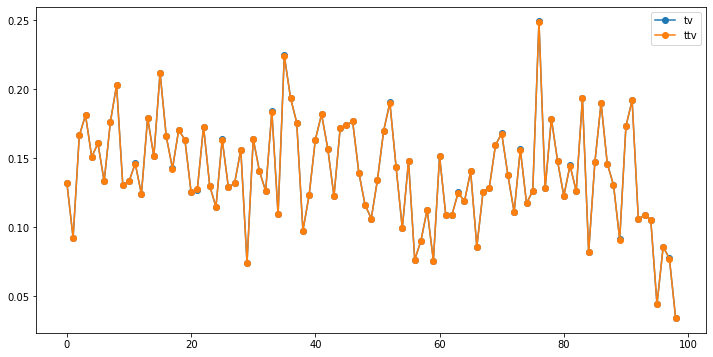

In [16]:
plt.figure(figsize=(12,6))
plt.plot(range(99), skl_tv['ferror'], 'o-', label='tv')
plt.plot(range(99), skl_ttv['ferror'], 'o-', label='ttv')
plt.legend()
plt.show()